In [ ]:
!cp drive/MyDrive/dataset_crochets_to_pattern.zip .
!unzip dataset_crochets_to_pattern.zip

In [ ]:
!pip install git+https://github.com/huggingface/transformers.git@main

In [2]:
!pip install -q datasets

In [3]:
from datasets import load_dataset

dataset = load_dataset("imagefolder", data_dir="./dataset", split="train")
dataset

Resolving data files:   0%|          | 0/5936 [00:00<?, ?it/s]

Dataset({
    features: ['image', 'additional_feature'],
    num_rows: 5935
})

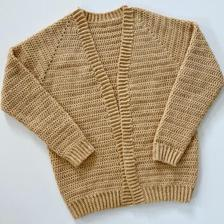

In [4]:
dataset[0]["image"]

In [5]:
dataset[0]["additional_feature"]

' BEGINNER CROCHET CARDIGAN Thank you for downloading a Little Golden Nook Designs pattern. This pattern comes in nine adult sizes XS through to 5XL. The pattern is written in US terms. Skill level is Absolute Beginner, with full video and photo tutorials for all techniques. This pattern is for personal use only. Please feel free to share your finished garment on Instagram/facebook, tagging me @littlegoldennook and using the hashtag #littlegoldennook and #helloseptembercardigan. Please don’t sell, forward, change or claim this pattern as your own. You may sell your finished garment ensuring you give credit to me for the design. Please ask permission before sharing my photos. MATERIALS 10ply/Aran/Worsted/Medium weight yarn XS 1200m S 1350m M 1500m L 1600m XL 1750m 2XL 1850m 3XL 2000m 4XL 2100m 5XL 2200m *Paintbox Yarns Simply Aran - 7 8 9 9 10 10 11 11 12 skeins (pictured cardigan is Light Caramel 208) -H/5mm hook -G/4.5mm hook -Tapestry needle GAUGE + MEASUREMENTS Double crochet stitch

In [6]:
from transformers import AutoProcessor, BlipForConditionalGeneration

processor = AutoProcessor.from_pretrained("Salesforce/blip-image-captioning-large")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-large")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
import torch
from torch.nn.utils.rnn import pad_sequence

def preprocess_data(dataset, processor):
    preprocessed_data = []
    count = 1
    for item in dataset:
        print(count)
        count += 1
        encoding = processor(images=item["image"], text=item["additional_feature"], padding="longest", return_tensors="pt")
        # remove batch dimension
        encoding = {k: v.squeeze() for k, v in encoding.items()}

        # Truncate input_ids and attention_mask to max_length 512
        max_length = 512
        if len(encoding["input_ids"]) > max_length:
            encoding["input_ids"] = encoding["input_ids"][:max_length]
            encoding["attention_mask"] = encoding["attention_mask"][:max_length]
        else:
            padding_length = max_length - len(encoding["input_ids"])
            padding_tensor = torch.zeros(padding_length, dtype=torch.long)
            padding_mask = torch.zeros(padding_length, dtype=torch.long)
            encoding["input_ids"] = torch.cat((encoding["input_ids"], padding_tensor), dim=0)
            encoding["attention_mask"] = torch.cat((encoding["attention_mask"], padding_mask), dim=0)

        preprocessed_data.append(encoding)

    return preprocessed_data

# Preprocess your data
preprocessed_data = preprocess_data(dataset, processor)

In [8]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(preprocessed_data, shuffle=True, batch_size=4)

In [9]:
import torch

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()

for epoch in range(5):
    print("Epoch:", epoch)
    total_correct = 0
    total_samples = 0

    for idx, batch in enumerate(train_dataloader):
        input_ids = batch.pop("input_ids").to(device)
        pixel_values = batch.pop("pixel_values").to(device)

        with torch.autocast(device_type='cuda', dtype=torch.float16):
            outputs = model(input_ids=input_ids,
                            pixel_values=pixel_values,
                            labels=input_ids)

        loss = outputs.loss
        print("Loss:", loss.item())

        # Calcula las predicciones
        predictions = outputs.logits.argmax(dim=-1)

        # Calcula la cantidad de predicciones correctas en este batch
        batch_correct = (predictions == input_ids).sum().item()
        total_correct += batch_correct

        # Calcula el tamaño total del batch
        total_samples += input_ids.size(0)

        loss.backward()

        optimizer.step()
        optimizer.zero_grad()
    # Calcula la precisión al final de cada época
    accuracy = total_correct / total_samples
    print("Epoch:", epoch, "Accuracy:", accuracy)

Epoch: 0
Loss: 9.136334419250488
Loss: 10.135473251342773
Loss: 10.241501808166504


We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Streaming output truncated to the last 5000 lines.
Loss: 2.1190783977508545
Loss: 1.5531619787216187
Loss: 1.1428850889205933
Loss: 1.702073097229004
Loss: 1.7402186393737793
Loss: 1.6790614128112793
Loss: 1.3010026216506958
Loss: 1.356734275817871
Loss: 2.096224546432495
Loss: 2.4424498081207275
Loss: 1.4395368099212646
Loss: 1.8764097690582275
Loss: 2.2665798664093018
Loss: 1.2326239347457886
Loss: 1.919644832611084
Loss: 2.147890567779541
Loss: 1.612788438796997
Loss: 1.9463260173797607
Loss: 2.3363609313964844
Loss: 1.5734505653381348
Loss: 2.1713438034057617
Loss: 1.8061237335205078
Loss: 2.1128687858581543
Loss: 1.807849407196045
Loss: 2.2041428089141846
Loss: 1.8253923654556274
Loss: 2.9141764640808105
Loss: 2.2448530197143555
Loss: 1.8235154151916504
Loss: 1.9963114261627197
Loss: 2.543290615081787
Loss: 1.4708975553512573
Loss: 2.698101758956909
Loss: 1.9663479328155518
Loss: 1.695544719696045
Loss: 1.3508764505386353
Loss: 2.538804292678833
Loss: 1.9454302787780762
Loss: 1.96

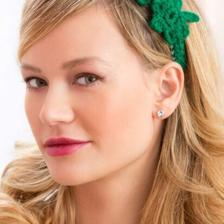

In [16]:
# load image
example = dataset[4822]
image = example["image"]
image

In [17]:
inputs = processor(images=image, return_tensors="pt").to(device)
pixel_values = inputs.pixel_values

generated_ids = model.generate(pixel_values=pixel_values, max_length=512)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_caption)

www. redheart. com for more ideas & inspiration — www. redheart. com www. coatsandclark. com www. crochettoday. com www. knitandcrochettoday. com ©2008 coats & clark p. o. box 12229 greenville, sc 29612 - 0229 crochet granny square throw lw1594 designed by mary jane protus. throw measures 45 ” x 56 ”. red heart® “ super saver® ” : 3 skeins each 311 white a and 316 soft white b. crochet hook : 6mm [ us j - 10 ]. yarn needle. gauge : 6 sts = 4 ” ; 6 rows = 4 ” in pattern. check your gauge. use any size hook to obtain the gauge. special abbreviations : dc2tog : [ yo and draw up a loop in next st ] twice, yo and draw through all 3 loops on hook. dc3tog : [ yo and draw up a loop in next st ] twice, yo and draw through all 3 loops on hook. dc4tog : [ yo and draw up a loop in next st ] twice, yo and draw through all 3 loops on hook. dc4tog : [ yo and draw up a loop in next st ] twice, yo and draw through all 3 loops on hook. dc4tog : [ yo and draw up a loop in next st ] twice, yo and draw thr

In [16]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
model.save_pretrained("blip-image-captioning-large-crochet-pattern-finetuned-3")
processor.save_pretrained("blip-image-captioning-large-crochet-pattern-finetuned-3")

In [24]:
import locale
print(locale.getpreferredencoding())

UTF-8


In [23]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [20]:
!zip -r blip-image-captioning-large-crochet-pattern-finetuned-3.zip blip-image-captioning-large-crochet-pattern-finetuned-3

  adding: blip-image-captioning-large-crochet-pattern-finetuned-3/ (stored 0%)
  adding: blip-image-captioning-large-crochet-pattern-finetuned-3/config.json (deflated 55%)
  adding: blip-image-captioning-large-crochet-pattern-finetuned-3/preprocessor_config.json (deflated 58%)
  adding: blip-image-captioning-large-crochet-pattern-finetuned-3/special_tokens_map.json (deflated 80%)
  adding: blip-image-captioning-large-crochet-pattern-finetuned-3/tokenizer.json (deflated 71%)
  adding: blip-image-captioning-large-crochet-pattern-finetuned-3/vocab.txt (deflated 53%)
  adding: blip-image-captioning-large-crochet-pattern-finetuned-3/generation_config.json (deflated 26%)
  adding: blip-image-captioning-large-crochet-pattern-finetuned-3/model.safetensors (deflated 7%)
  adding: blip-image-captioning-large-crochet-pattern-finetuned-3/tokenizer_config.json (deflated 74%)


In [22]:
!cp blip-image-captioning-large-crochet-pattern-finetuned-3.zip /content/drive/MyDrive/